Comment to the notebook:

There is few issues with visualization, it looks very random. I was thinking about what might cause that and realize that in class notebook we selected only fragment of the images enlarging them thus letting xai show us something that can be interpreted.

Moreover I lost a lot of time not seeing anything on CDAM output. To be honest I had trouble understandig what target_idx is supposed to be. It isn't explained in source code, only with 1 of tutorials. 2nd porblem was with selecting the layer to create a hook on, due to change of models I didn't know what to select and why traing to find any layer to show something I either had no meaningful output or error with dimensions :(

In [1]:
!pip install --quiet obzai medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━

In [2]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.optim as optim
import torch
from torch import nn
import numpy as np
import gdown
import os
import matplotlib.pyplot as plt
import obzai
from transformers import ViTConfig, ViTModel
from medmnist import BreastMNIST

In [3]:
class ViT_BreastMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config)
        self.head = nn.Linear(config.hidden_size, 1)  # Binary classification (benign vs malignant)

    def forward(self, x, output_attentions=False):
        out = self.vit(x, output_attentions=output_attentions)
        x = out.pooler_output
        x = self.head(x)
        if output_attentions:
            return x, out.attentions
        return x

In [4]:
# BreastMNIST is grayscale (1 channel), convert to 3 channels
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Lambda(lambda img: img.convert('RGB')),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_data = BreastMNIST(split='train', transform=transform, download=True)
val_data = BreastMNIST(split='val', transform=transform, download=True)
test_data = BreastMNIST(split='test', transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 560k/560k [00:00<00:00, 716kB/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_BreastMNIST().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 18

total_train = len(train_loader.dataset)
total_val = len(val_loader.dataset)

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().squeeze(1).to(device)

        logits = model(imgs)
        loss = criterion(logits.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        predictions = torch.sigmoid(logits).round().squeeze()
        correct += (predictions == labels).sum().item()

    epoch_loss = running_loss / total_train
    epoch_acc = correct / total_train

    # --- Validation ---
    model.eval()
    val_correct = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.float().squeeze(1).to(device)

            logits = model(imgs)

            predictions = torch.sigmoid(logits).round().squeeze()
            val_correct += (predictions == labels).sum().item()

    val_acc = val_correct / total_val

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {epoch_loss:.4f}, Train Acc = {epoch_acc:.4f} | "
          f"Val Acc = {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: Train Loss = 0.5795, Train Acc = 0.7198 | Val Acc = 0.7308
Epoch 2: Train Loss = 0.5073, Train Acc = 0.7308 | Val Acc = 0.7308
Epoch 3: Train Loss = 0.4481, Train Acc = 0.7894 | Val Acc = 0.8205
Epoch 4: Train Loss = 0.3797, Train Acc = 0.8700 | Val Acc = 0.8590
Epoch 5: Train Loss = 0.3160, Train Acc = 0.9194 | Val Acc = 0.8846
Epoch 6: Train Loss = 0.2500, Train Acc = 0.9432 | Val Acc = 0.8846
Epoch 7: Train Loss = 0.2025, Train Acc = 0.9579 | Val Acc = 0.8718
Epoch 8: Train Loss = 0.1638, Train Acc = 0.9652 | Val Acc = 0.8590
Epoch 9: Train Loss = 0.1385, Train Acc = 0.9689 | Val Acc = 0.8462
Epoch 10: Train Loss = 0.1184, Train Acc = 0.9707 | Val Acc = 0.8718
Epoch 11: Train Loss = 0.1034, Train Acc = 0.9707 | Val Acc = 0.8590
Epoch 12: Train Loss = 0.0876, Train Acc = 0.9744 | Val Acc = 0.8462
Epoch 13: Train Loss = 0.0737, Train Acc = 0.9817 | Val Acc = 0.8590
Epoch 14: Train Loss = 0.0622, Train Acc = 0.9817 | Val Acc = 0.8590
Epoch 15: Train Loss = 0.0530, Train Acc = 

In [6]:
model.eval()
test_correct = 0
total_test = len(test_loader.dataset)

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.float().squeeze(1).to(device)

        logits = model(imgs)
        predictions = torch.sigmoid(logits).round().squeeze()
        test_correct += (predictions == labels).sum().item()

test_acc = test_correct / total_test

print(f"Test Accuracy = {test_acc:.4f}")

Test Accuracy = 0.8718


In [7]:
# Labels mapping
CLASS_NAMES = ["benign", "malignant"]

LOGIT2NAME = {
    0: "benign",
    1: "malignant",
}

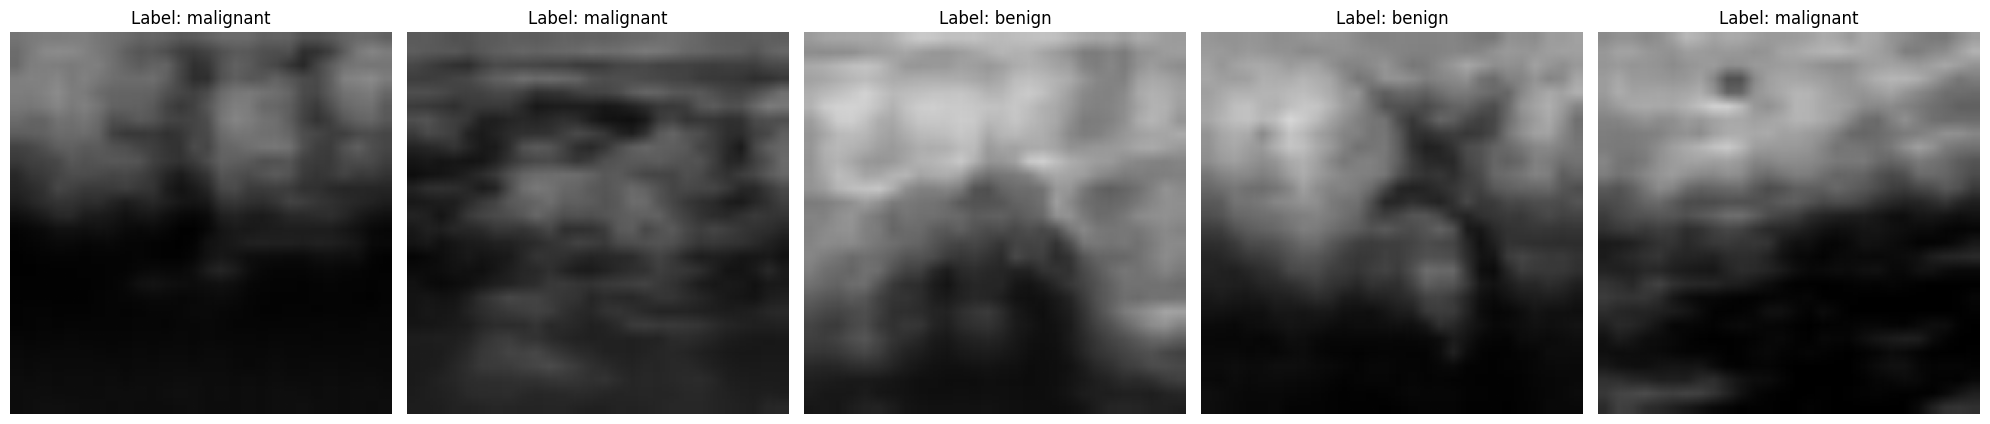

In [8]:
# Visualize the first 5 samples from test dataset
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Get a batch of test samples
samples, labels = next(iter(test_loader))

# Unnormalize the batch
unnorm_samples = samples * std + mean  # shape [B, C, H, W]

# Plot the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image = unnorm_samples[i].permute(1, 2, 0).numpy().clip(0, 1)  # HWC and clamp
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {CLASS_NAMES[int(labels[i].item())]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Move samples to the appropriate device
samples = samples[:5].to(device)
labels = labels[:5].to(device)
print(labels)
print(samples.shape)

# Dont normalize the LIDC data?
# Normalize the samples
#samples = NORMALIZE(samples)

# Perform inference using the model
with torch.no_grad():
    logits = model(samples)
    predictions = torch.sigmoid(logits).round().squeeze().cpu().numpy()

# Map predictions to class names
predicted_classes = [LOGIT2NAME[int(pred)] for pred in predictions]

# Print the results
for i, pred_class in enumerate(predicted_classes):
    print(f"Prediction for Sample {i + 1}: {pred_class}")

tensor([[1],
        [1],
        [0],
        [0],
        [1]], device='cuda:0')
torch.Size([5, 3, 224, 224])
Prediction for Sample 1: malignant
Prediction for Sample 2: malignant
Prediction for Sample 3: benign
Prediction for Sample 4: malignant
Prediction for Sample 5: malignant


In [28]:
from obzai.xai.xai_tool import CDAM, AttentionMap

# Choose desired XAI Tools
cdam_tool = CDAM(model=model,
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_logits",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)

# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="vit.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=model,
                              attention_layer_id = -1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )

In [11]:
# Apply attention_tool on the first ten samples
attention_maps = attention_tool.explain(samples)  # Use the appropriate method to generate attention maps

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


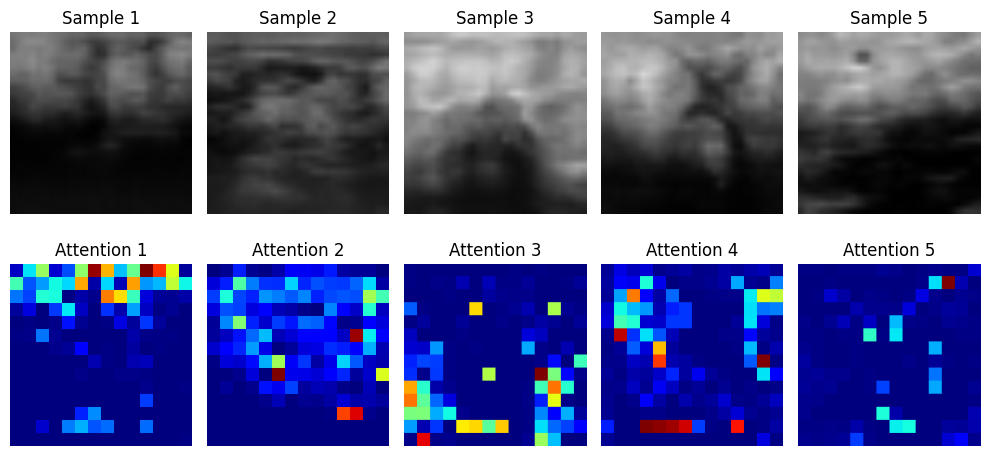

In [12]:
# Visualize samples and attention maps
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# First row: Original samples
for i in range(5):
    original_image = unnorm_samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Attention maps
for i in range(5):
    attention_map = attention_maps[i].cpu().numpy()
    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

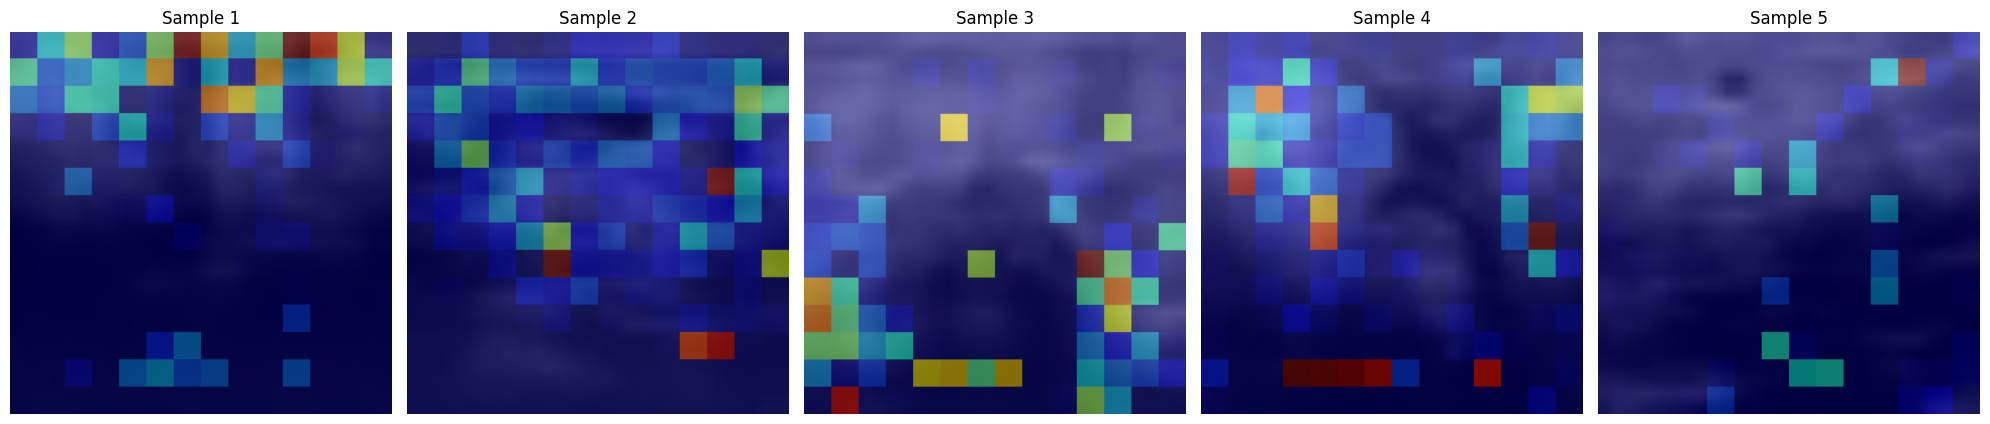

In [13]:
# Visualize attention maps overlaid on samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    original_image = unnorm_samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    attention_map = attention_maps[i].cpu().numpy()  # Convert attention map to numpy array

    # Overlay attention map on the original image
    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)  # Use alpha for transparency
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Generate CDAM maps
cdam_maps = cdam_tool.explain(samples, target_idx=[0, 0, 0, 0, 0])

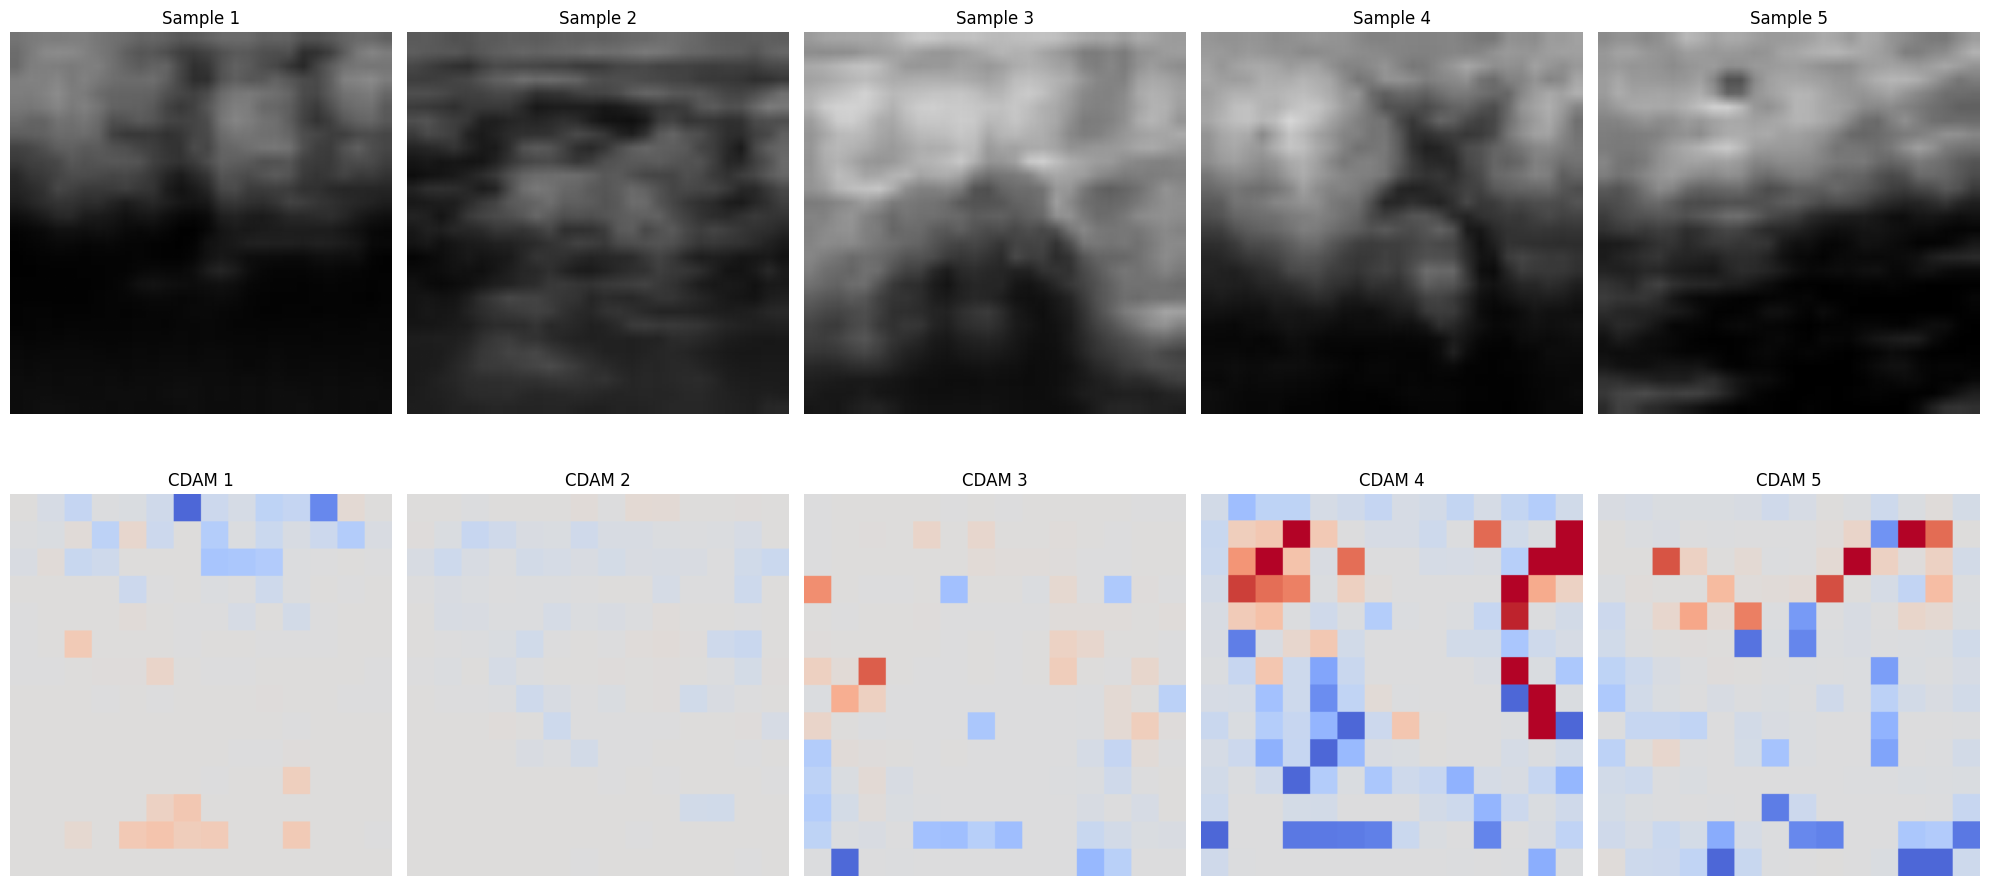

In [30]:
# Visualize samples and CDAM maps
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# First row: Original samples
for i in range(5):
    original_image = unnorm_samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: CDAM maps
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Diverging colormap
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

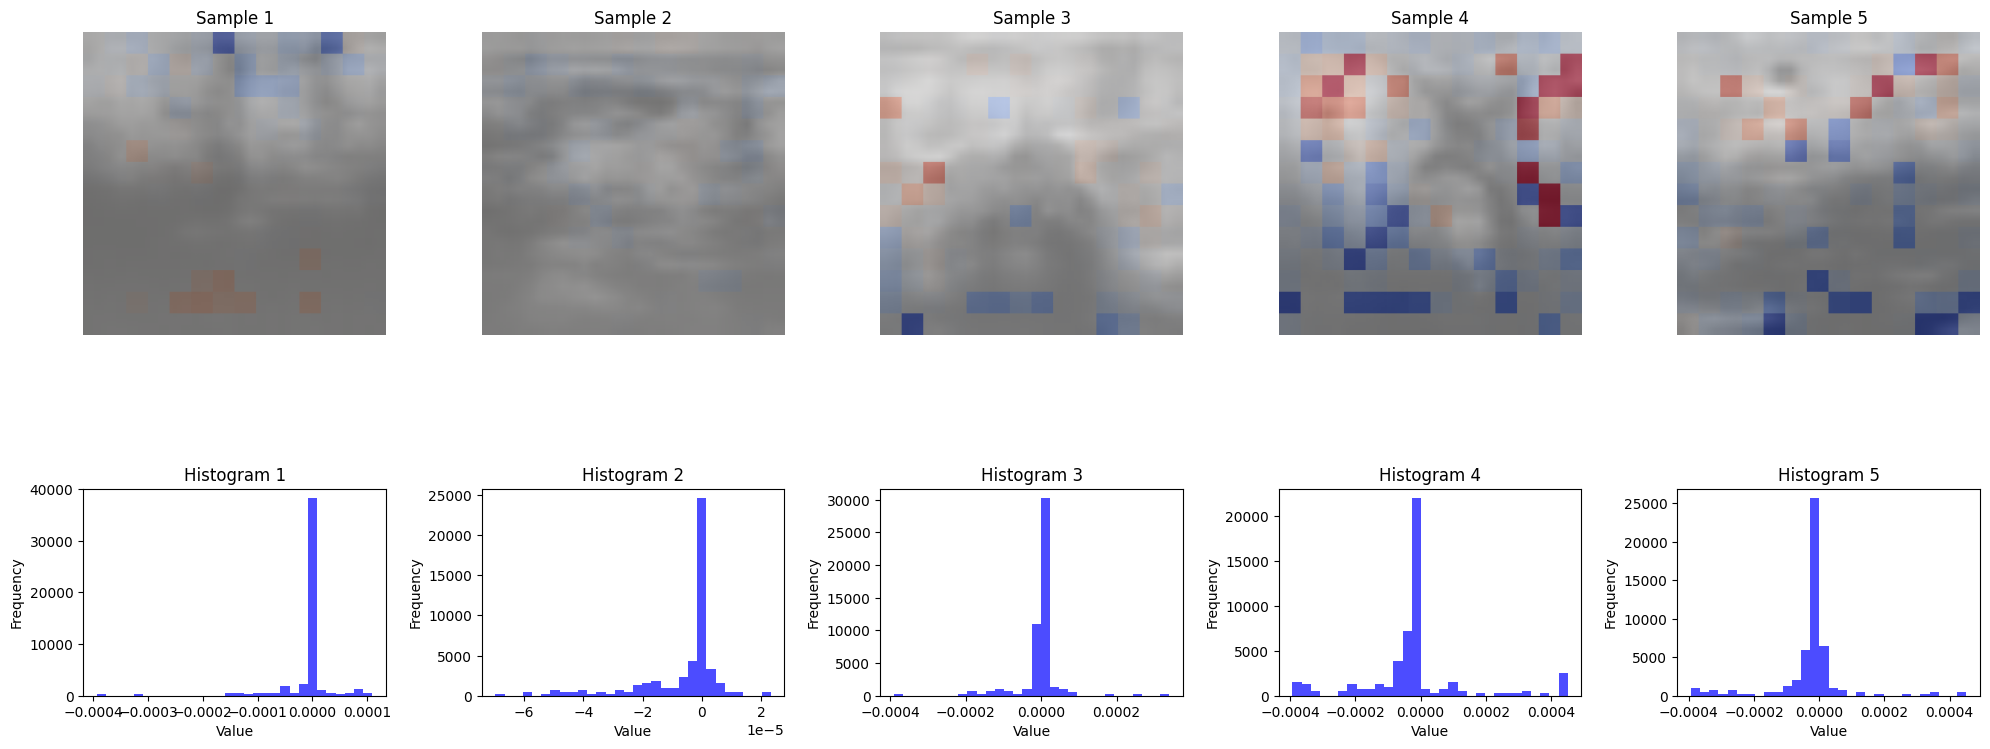

In [31]:
# Visualize CDAM maps overlaid on samples with histogram and color bar
fig, axes = plt.subplots(2, 5, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})

# First row: Original samples with overlaid CDAM maps
for i in range(5):
    original_image = unnorm_samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array

    # Overlay CDAM map on the original image
    im = axes[0, i].imshow(original_image, cmap='gray')
    im = axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Use alpha for transparency
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Histogram of CDAM map values
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()